<a href="https://colab.research.google.com/github/sarmi2325/Pneunomia_detection_training_colabfiles/blob/main/Resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Connecting to the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data import AUTOTUNE

# Set path to your dataset
data_dir = '/content/drive/MyDrive/chest_xray (1)'

#Resizing image and configuring batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load training data
train_ds = image_dataset_from_directory(
    directory=f"{data_dir}/train",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

#Load validation data
val_ds = image_dataset_from_directory(
    directory=f"{data_dir}/val",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Load test data
test_ds = image_dataset_from_directory(
    directory=f"{data_dir}/test",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Prefetch batch for optimized performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 6818 files belonging to 2 classes.
Found 1172 files belonging to 2 classes.
Found 586 files belonging to 2 classes.


In [3]:
from tensorflow.keras import layers

#Implementing Data Augmentation for better generalization and to avoid overfitting
#Since it is a medical dataset, heavy data augumentation will mislead the data. Hence brightness and contrast is implemented
data_augmentation = tf.keras.Sequential([
    layers.RandomBrightness(factor=0.2),  # Brightness adjustment ±20%
    layers.RandomContrast(factor=0.2) ,    # Contrast adjustment ±20%
    layers.RandomZoom(0.1),
])

In [4]:
#import libraries for training the model
from tensorflow.keras import models
from keras.applications import ResNet50 #chossing EfficientNetB0 as it is a light weight model and give better accuracy for binary image classification
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [5]:
# Load ResNet50 base (simulate ResNet18 by using fewer layers)
base_model = ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze base layers

# Build model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, verbose=1)

# Train
print("Training with frozen ResNet base...")
history_frozen = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=6,
    callbacks=[early_stop, reduce_lr]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training with frozen ResNet base...
Epoch 1/6
214/214 ━━━━━━━━━━━━━━━━━━━━ 1386s 6s/step - accuracy: 0.7389 - loss: 0.5446 - val_accuracy: 0.9061 - val_loss: 0.2435 - learning_rate: 1.0000e-04
Epoch 2/6
214/214 ━━━━━━━━━━━━━━━━━━━━ 115s 422ms/step - accuracy: 0.8798 - loss: 0.2862 - val_accuracy: 0.9300 - val_loss: 0.1713 - learning_rate: 1.0000e-04
Epoch 3/6
214/214 ━━━━━━━━━━━━━━━━━━━━ 141s 417ms/step - accuracy: 0.8950 - loss: 0.2490 - val_accuracy: 0.9394 - val_loss: 0.1526 - learning_rate: 1.0000e-04
Epoch 4/6
214/214 ━━━━━━━━━━━━━━━━━━━━ 141s 416ms/step - accuracy: 0.9089 - loss: 0.2229 - val_accuracy: 0.9394 - val_loss: 0.1449 - learning_rate: 1.0000e-04
Epoch 5/6
214/214 ━━━━━━━━━━━━━━━━━━━━ 142s 415ms/step - accuracy: 0.9153 - loss: 0.2061 - val_accuracy: 0.9445 - val_loss: 0.1413 - learning_rate: 1.0000e-04
Epoch 6/6
214/214 ━━━━━━━━━━━━━━━━━━━━ 90s 421ms/step - accuracy: 0.9298 - loss: 0.1788 - val_accuracy: 0.9437 - val_los

In [6]:
# Fine-tuning the last 30 layers
print("Unfreezing last 30 layers for fine-tuning...")
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile with smaller LR
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Fine-tune
print("Fine-tuning ResNet50...")
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

# Save fine-tuned model
model.save("resnet50_finetuned.keras")
print("Model saved as 'resnet50_finetuned.keras'")

Unfreezing last 30 layers for fine-tuning...
Fine-tuning ResNet50...
Epoch 1/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 100s 401ms/step - accuracy: 0.9252 - auc: 0.9759 - loss: 0.1963 - val_accuracy: 0.9471 - val_auc: 0.9930 - val_loss: 0.1438 - learning_rate: 1.0000e-05
Epoch 2/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 147s 429ms/step - accuracy: 0.9625 - auc: 0.9923 - loss: 0.1087 - val_accuracy: 0.9531 - val_auc: 0.9944 - val_loss: 0.1250 - learning_rate: 1.0000e-05
Epoch 3/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 134s 391ms/step - accuracy: 0.9689 - auc: 0.9950 - loss: 0.0863 - val_accuracy: 0.9565 - val_auc: 0.9951 - val_loss: 0.1022 - learning_rate: 1.0000e-05
Epoch 4/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 150s 429ms/step - accuracy: 0.9796 - auc: 0.9982 - loss: 0.0560 - val_accuracy: 0.9599 - val_auc: 0.9953 - val_loss: 0.0967 - learning_rate: 1.0000e-05
Epoch 5/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 142s 431ms/step - accuracy: 0.9827 - auc: 0.9980 - loss: 0.0530 - val_accuracy: 0.9676 - val_auc: 0.9957 - val_loss: 0.0864

In [7]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Get predicted probabilities
y_probs =model.predict(test_ds)
y_pred = (y_probs > 0.5).astype("int").flatten()

19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 387ms/step


In [8]:
# Accuracy
print(f"Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))



Accuracy: 95.90%

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.97      0.96       293
   PNEUMONIA       0.97      0.95      0.96       293

    accuracy                           0.96       586
   macro avg       0.96      0.96      0.96       586
weighted avg       0.96      0.96      0.96       586



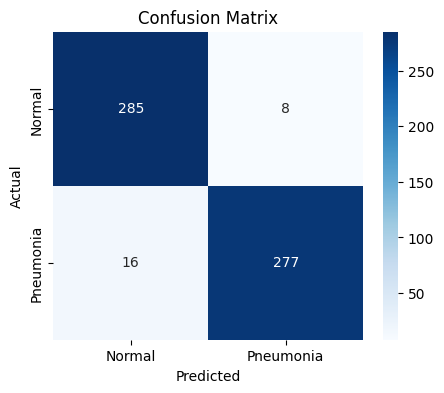

In [9]:

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [10]:
auc = roc_auc_score(y_true, y_probs)
print(f"AUC Score: {auc:.4f}")

AUC Score: 0.9920


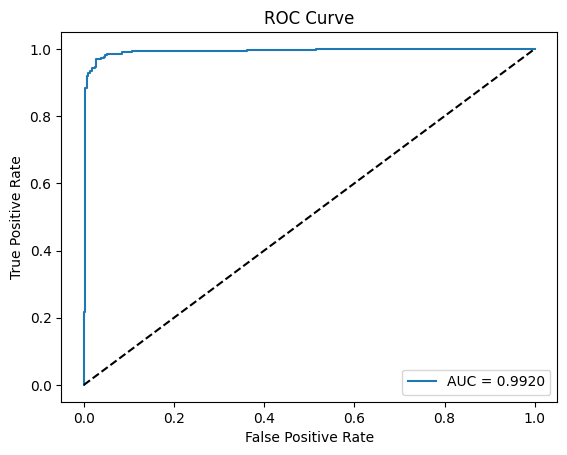

In [11]:

from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, y_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()